# Task 1


In [1]:
import os
from urllib.request import urlretrieve
#from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

In [2]:
url_dog="https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg"
urlretrieve(url_dog, "dog.jpg")

('dog.jpg', <http.client.HTTPMessage at 0x7cef7d7c5360>)

In [3]:
model = ResNet50(weights='imagenet', include_top=True)

102967424/102967424 [==============================] - 1s 0us/step


In [4]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [14]:
img_path = 'kokuszka.JPG'

img = image.load_img(img_path, target_size=(224, 224)) # ResNet50 esetén 224x224 a bemeneti kép mérete
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

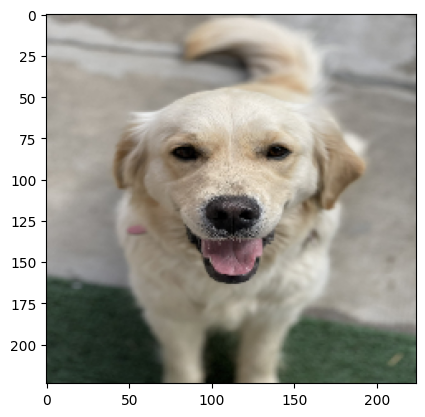

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)

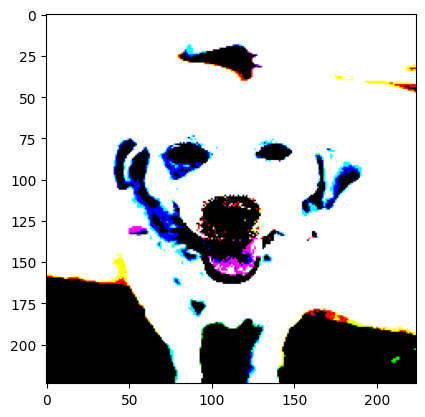

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x[0])

In [17]:
preds = model.predict(x)
print('Jósolt osztály:')
print(decode_predictions(preds))

1/1 [==============================] - 0s 134ms/step
Jósolt osztály:
[[('n02099601', 'golden_retriever', 0.834764), ('n02099712', 'Labrador_retriever', 0.13452162), ('n02104029', 'kuvasz', 0.009773555), ('n04409515', 'tennis_ball', 0.004187006), ('n02101388', 'Brittany_spaniel', 0.001997931)]]


# Task2


In [18]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -O imagenette2-160.tgz
!tar -xf imagenette2-160.tgz

--2023-10-12 11:33:59--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.62.176, 52.217.114.88, 52.216.219.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.62.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  88.7MB/s    in 1.1s    

2023-10-12 11:34:00 (88.7 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]



In [25]:
img_height=299
img_width=299
batch_size = 32

In [23]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

In [26]:
train_ds = image_dataset_from_directory("/content/imagenette2-160/train",
                                        label_mode='categorical',
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size)

Found 9469 files belonging to 10 classes.


In [27]:
val_ds =  image_dataset_from_directory("/content/imagenette2-160/val",
                                        label_mode='categorical',
                                        image_size=(img_height, img_width),
                                        batch_size=batch_size)

Found 3925 files belonging to 10 classes.


In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
import numpy as np

In [33]:
# előtanított modell betöltése, a fully-connected rétegek nélkül
base_model = InceptionV3(weights='imagenet', include_top=False)
# az utolsó konvolúciós réteg utána egy global average pooling réteget teszünk, ez rögtön "lapítja" (flatten) a 2D konvolúciót
x = base_model.output
x = GlobalAveragePooling2D()(x)
# ezután hozzáadunk egy előrecsatolt réteget ReLU aktivációs függvénnyel
x = Dense(1024, activation='relu')(x)
# és végül egy kimenete lesz a hálónak - a "binary_crossentropy" költségfüggvénynek erre van szüksége
predictions = Dense(10, activation='softmax')(x)
# a model létrehozása
model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
for layer in base_model.layers:
    layer.trainable = False

# lefordítjuk a modelt (fontos, hogy ezt a rétegek befagyasztása után csináljuk"
# mivel két osztályunk van, ezért bináris keresztentrópia költségfüggvényt használunk
model.compile(optimizer='adam', metrics=['accuracy'],loss='categorical_crossentropy')

In [ ]:
# ez a függvény egyszerre végzi az adatdúsítást és a háló tanítását
model.fit_generator(train_ds,steps_per_epoch=50,validation_data=val_ds,validation_steps=10,epochs=3)

Epoch 1/3


<ipython-input-37-93ad87f8dde4>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_ds,steps_per_epoch=50,validation_data=val_ds,validation_steps=10,epochs=3)


50/50 [==============================] - 322s 6s/step - loss: 38.3417 - accuracy: 0.1981 - val_loss: 8.8093 - val_accuracy: 0.2375
Epoch 2/3
50/50 [==============================] - 316s 6s/step - loss: 5.0549 - accuracy: 0.2994 - val_loss: 3.4087 - val_accuracy: 0.3625
Epoch 3/3
50/50 [==============================] - 313s 6s/step - loss: 3.4895 - accuracy: 0.3144 - val_loss: 3.5535 - val_accuracy: 0.2844
